In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from fastai.imports import *
from fastai.vision.all import *
import shutil
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import *


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# making a food classifier with transfer learning

in this notebook we use the [Food-101 dataset](https://www.kaggle.com/datasets/kmader/food41) and transfer learning to efficiently train a classification model to classify 101 categories of food

## loading our data

this dataset is also available in HDF5 format, we used [this]('https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-hdf5matrix-with-keras.md') post to get some more information about it en learn how to use it.

In [2]:
batch_size = 32
img_height = 224
img_width =224

In [3]:
import h5py
file = h5py.File('/kaggle/input/food41/food_c101_n1000_r384x384x3.h5', 'r')

images_train = file['images'][...]
category_labels_train = file['category'][...]#one-hot encoded representation of our labels
category_names_train = file['category_names'][...]#name of each category

file.close()

file = h5py.File('/kaggle/input/food41/food_test_c101_n1000_r128x128x3.h5', 'r')

images_test = file['images'][...]
category_labels_test = file['category'][...]
category_names_test = file['category_names'][...]

file.close()

In [4]:
labels_train = np.where(category_labels_train == True)[1]
labels_test = np.where(category_labels_test == True)[1]

In [5]:
np.argmax(category_labels_test,axis=1).shape,images_test.shape

((1000,), (1000, 128, 128, 3))

In [6]:
# Split the training set into training and validation
images_val, images_train = images_train[0:int(len(images_train)*0.2)], images_train[int(len(images_train)*0.2):]
category_labels_val, category_labels_train = labels_train[0:int(len(labels_train)*0.2)], labels_train[int(len(labels_train)*0.2):]
category_names_val, category_names_train = category_names_train[0:int(len(category_names_train)*0.2)], category_names_train[int(len(category_names_train)*0.2):]

In [7]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.03),
    layers.RandomZoom(height_factor=(-0.1, 0.1)),
    layers.RandomContrast(factor=0.05),
])

2022-12-15 11:43:58.026061: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 11:43:58.027143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 11:43:58.028218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 11:43:58.028982: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 11:43:58.029799: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

We will not rescale the images because the pretrained models that we're going to use already have a rescaling layer.(We realised this after spending countles hours optimising our models and swapping out architectures (っ °Д °;)っ

In [8]:
resize = tf.keras.Sequential([
  layers.Resizing(img_width, img_height),
])

In [9]:
class_names=[]

In [10]:
fo = open("/kaggle/input/food41/meta/meta/labels.txt")
for line in fo:
    class_names.append(line)
fo.close()

In [11]:
def prepare_dataset(image,label, batch_size=32, b_shuffle=True,augment=True):
    # transform input data into tf.data
    ds = tf.data.Dataset.from_tensor_slices((image, label))

    ds = ds.map(map_func = preprocessing ,num_parallel_calls = tf.data.experimental.AUTOTUNE)
    # normally you only need to shuffle the training data
    if b_shuffle == True:
        ds = ds.shuffle(len(ds))
    # normally you only need to augment the training data
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.cache()
    ds = ds.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return ds



def preprocessing(image, label):
    image = resize(image)
    return image, label


train_ds = prepare_dataset(images_train, category_labels_train,augment=True)
val_ds = prepare_dataset(images_val, category_labels_val, b_shuffle = False,augment=False)
test_ds = prepare_dataset(images_test,labels_test, b_shuffle = False,augment=False)

2022-12-15 11:44:10.616472: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-15 11:44:12.006115: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


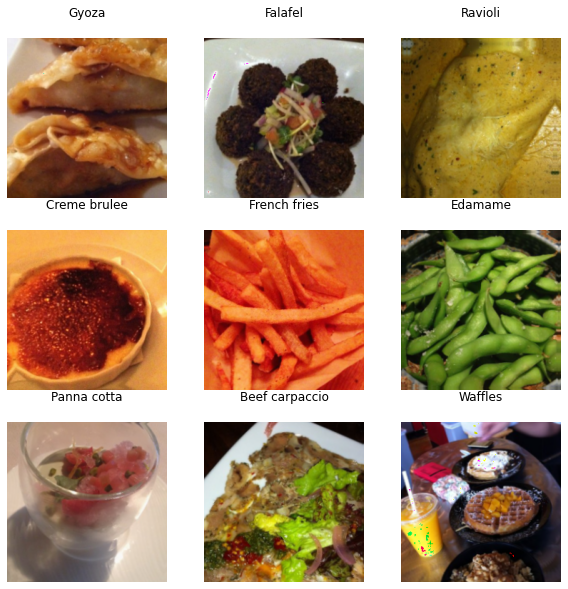

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Testing out different architectures and methods

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_sparse_categorical_accuracy',
    patience=20,
    min_delta=1e-4,
    restore_best_weights=True,
)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_sparse_categorical_accuracy',
    factor=0.2,                                     
    patience=10,                                   
    min_delta=1e-4,
    cooldown=0,                               
    verbose=1
) 

### EfficientNetB3 with fine tuning the top layer

In [15]:
EfficientNetB3=tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(img_width, img_width, 3),
    pooling=None,
    classes=101,
)

43950080/43941136 [==============================] - 0s 0us/step


In [16]:
base_out = EfficientNetB3.output
x = tf.keras.layers.GlobalAveragePooling2D()(base_out)
output = layers.Dense(len(class_names), activation='softmax')(x)

model_TL = models.Model(EfficientNetB3.input, output)

In [17]:
len(EfficientNetB3.layers)

384

we will first freeze the base model and train our classification layers on top because we don't want to break our models weights.The pretrained weights we're using are from Imagenet. We have a chance of breaking the pretrained model because our source domain is much different from our target domain. Generaly only the lower level layers (that recognize less complex shapes) will be usefull for us. The further on top the node is, the more specialized it becomes at detecting specific elements in images.

In [18]:
# freezing the base_model:
for layer in EfficientNetB3.layers[:]:
    layer.trainable = False

In [19]:
from tensorflow.keras.optimizers import Adam
model_TL.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                 optimizer="adam",                 
                 metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [20]:
history = model_TL.fit(train_ds,
                         validation_data=val_ds,
                         epochs=2,
                         verbose=1)

Epoch 1/2


2022-12-15 11:44:28.288637: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


25/25 [==============================] - 32s 430ms/step - loss: 4.5457 - sparse_categorical_accuracy: 0.0475 - val_loss: 4.2046 - val_sparse_categorical_accuracy: 0.1000
Epoch 2/2
25/25 [==============================] - 4s 150ms/step - loss: 3.3823 - sparse_categorical_accuracy: 0.3988 - val_loss: 3.7414 - val_sparse_categorical_accuracy: 0.2150


look at the loss curves

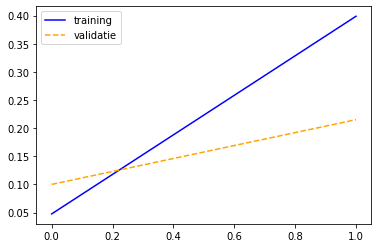

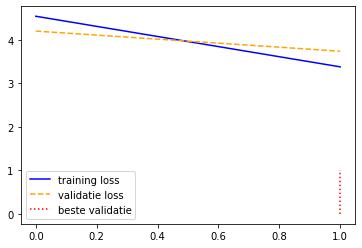

In [21]:
train_loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
best_val_idx = np.argmin(val_loss_values)
num_epochs = range(len(train_loss_values))

plt.plot(num_epochs, train_loss_values, label='training loss', color='blue', ls='-')
plt.plot(num_epochs, val_loss_values, label='validatie loss', color='orange', ls='--')
plt.vlines(x=best_val_idx, ymin=0, ymax=1, label='beste validatie', color='red', ls=':')
plt.legend()
plt.figure(0)
train_loss_values = history.history['sparse_categorical_accuracy']
val_loss_values = history.history['val_sparse_categorical_accuracy']
num_epochs = range(len(train_loss_values))

plt.plot(num_epochs, train_loss_values, label='training', color='blue', ls='-')
plt.plot(num_epochs, val_loss_values, label='validatie', color='orange', ls='--')
plt.legend()
plt.figure(1)
plt.show()

In [22]:
loss, categorical_accuracy = model_TL.evaluate(test_ds, verbose=1)
loss, categorical_accuracy 

32/32 [==============================] - 4s 129ms/step - loss: 3.7561 - sparse_categorical_accuracy: 0.2020


(3.7560923099517822, 0.20200000703334808)

In [23]:
# unfreezing the base model but keeping the first 190 weights frozen:

for layer in EfficientNetB3.layers[:190]:
    layer.trainable = False
    
for layer in EfficientNetB3.layers[190:]:
    layer.trainable = True

recompile the model with slow LR

In [24]:
model_TL.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                 optimizer=Adam(
                learning_rate=0.0002,
                beta_1=0.9,
                beta_2=0.999,
                epsilon=1e-08 ),                 
                 metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [25]:
history = model_TL.fit(train_ds,
                         validation_data=val_ds,
                         epochs=20,
                         callbacks=[early_stopping, plateau],
                         verbose=1)

Epoch 1/20
25/25 [==============================] - 20s 328ms/step - loss: 3.8172 - sparse_categorical_accuracy: 0.2113 - val_loss: 3.5422 - val_sparse_categorical_accuracy: 0.2550
Epoch 2/20
25/25 [==============================] - 6s 244ms/step - loss: 2.0226 - sparse_categorical_accuracy: 0.8537 - val_loss: 3.3182 - val_sparse_categorical_accuracy: 0.2900
Epoch 3/20
25/25 [==============================] - 6s 245ms/step - loss: 1.0342 - sparse_categorical_accuracy: 0.9688 - val_loss: 3.1517 - val_sparse_categorical_accuracy: 0.3100
Epoch 4/20
25/25 [==============================] - 6s 247ms/step - loss: 0.5005 - sparse_categorical_accuracy: 0.9937 - val_loss: 3.0653 - val_sparse_categorical_accuracy: 0.3300
Epoch 5/20
25/25 [==============================] - 6s 248ms/step - loss: 0.2747 - sparse_categorical_accuracy: 1.0000 - val_loss: 3.0191 - val_sparse_categorical_accuracy: 0.3350
Epoch 6/20
25/25 [==============================] - 6s 249ms/step - loss: 0.1871 - sparse_categoric

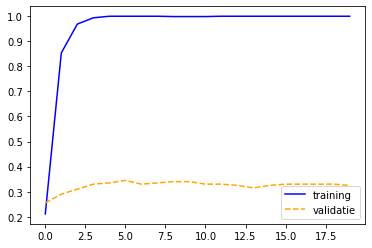

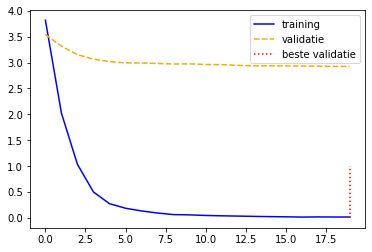

In [26]:
train_loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
best_val_idx = np.argmin(val_loss_values)
num_epochs = range(len(train_loss_values))

plt.plot(num_epochs, train_loss_values, label='training', color='blue', ls='-')
plt.plot(num_epochs, val_loss_values, label='validatie', color='orange', ls='--')
plt.vlines(x=best_val_idx, ymin=0, ymax=1, label='beste validatie', color='red', ls=':')
plt.legend()
plt.figure(0)
train_loss_values = history.history['sparse_categorical_accuracy']
val_loss_values = history.history['val_sparse_categorical_accuracy']
num_epochs = range(len(train_loss_values))

plt.plot(num_epochs, train_loss_values, label='training', color='blue', ls='-')
plt.plot(num_epochs, val_loss_values, label='validatie', color='orange', ls='--')
plt.legend()
plt.figure(1)
plt.show()

In [27]:
loss, categorical_accuracy = model_TL.evaluate(test_ds, verbose=1)
loss, categorical_accuracy 

32/32 [==============================] - 4s 113ms/step - loss: 3.1389 - sparse_categorical_accuracy: 0.2860


(3.1389036178588867, 0.28600001335144043)

In [28]:
model_TL.save_weights('EfficientNetB3_finetuned.h5')

### EfficientNetB3 finetune with a more complex top layer

In [29]:
EfficientNetB3=tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(img_width, img_width, 3),
    pooling=None,
    classes=101,
)

base_out = EfficientNetB3.output
x = tf.keras.layers.GlobalAveragePooling2D()(base_out)
x = layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(class_names), activation='softmax')(x)

model_TL_complex = models.Model(EfficientNetB3.input, output)

# freezing the base_model:
for layer in EfficientNetB3.layers[:]:
    layer.trainable = False

from tensorflow.keras.optimizers import Adam
model_TL_complex.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                 optimizer="adam",                 
                 metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

history = model_TL_complex.fit(train_ds,
                         validation_data=val_ds,
                         epochs=4,
                         verbose=1)
# unfreezing the base model but keeping the first 190 weights frozen:

for layer in EfficientNetB3.layers[:190]:
    layer.trainable = False
    
for layer in EfficientNetB3.layers[190:]:
    layer.trainable = True

model_TL_complex.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                 optimizer=Adam(
                learning_rate=0.0002,
                beta_1=0.9,
                beta_2=0.999,
                epsilon=1e-08 ),                 
                 metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

history = model_TL_complex.fit(train_ds,
                         validation_data=val_ds,
                         epochs=20,
                         callbacks=[early_stopping, plateau],
                         verbose=1)

Epoch 1/4
25/25 [==============================] - 14s 236ms/step - loss: 5.0644 - sparse_categorical_accuracy: 0.0300 - val_loss: 4.8184 - val_sparse_categorical_accuracy: 0.1150
Epoch 2/4
25/25 [==============================] - 4s 155ms/step - loss: 4.2744 - sparse_categorical_accuracy: 0.2000 - val_loss: 4.4549 - val_sparse_categorical_accuracy: 0.1800
Epoch 3/4
25/25 [==============================] - 4s 154ms/step - loss: 3.5218 - sparse_categorical_accuracy: 0.3363 - val_loss: 4.0697 - val_sparse_categorical_accuracy: 0.2700
Epoch 4/4
25/25 [==============================] - 4s 158ms/step - loss: 2.8986 - sparse_categorical_accuracy: 0.4650 - val_loss: 3.7582 - val_sparse_categorical_accuracy: 0.3000
Epoch 1/20
25/25 [==============================] - 19s 343ms/step - loss: 4.0999 - sparse_categorical_accuracy: 0.2188 - val_loss: 3.7497 - val_sparse_categorical_accuracy: 0.3000
Epoch 2/20
25/25 [==============================] - 7s 262ms/step - loss: 2.8094 - sparse_categorical_

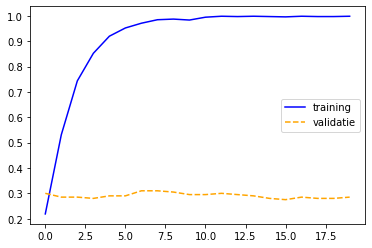

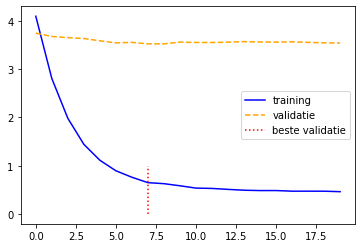

In [30]:
train_loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
best_val_idx = np.argmin(val_loss_values)
num_epochs = range(len(train_loss_values))

plt.plot(num_epochs, train_loss_values, label='training', color='blue', ls='-')
plt.plot(num_epochs, val_loss_values, label='validatie', color='orange', ls='--')
plt.vlines(x=best_val_idx, ymin=0, ymax=1, label='beste validatie', color='red', ls=':')
plt.legend()
plt.figure(0)
train_loss_values = history.history['sparse_categorical_accuracy']
val_loss_values = history.history['val_sparse_categorical_accuracy']
num_epochs = range(len(train_loss_values))

plt.plot(num_epochs, train_loss_values, label='training', color='blue', ls='-')
plt.plot(num_epochs, val_loss_values, label='validatie', color='orange', ls='--')
plt.legend()
plt.figure(1)
plt.show()

In [31]:
loss, categorical_accuracy = model_TL_complex.evaluate(test_ds, verbose=1)
loss, categorical_accuracy 

32/32 [==============================] - 4s 113ms/step - loss: 3.6564 - sparse_categorical_accuracy: 0.2840


(3.6563918590545654, 0.2840000092983246)

In [32]:
model_TL_complex.save_weights('EfficientNetB3_complex_finetuned.h5')

the more complex top layer did not make a big difference

### EfficientNetB3 with different fine tuning approach

instead of keeping the first 190 layers frozen we will try to see what the effect is if we keep the first 380 layers frozen and anly finetine a handfull of convolution layers on top instead of half of the pretrained model

In [33]:
EfficientNetB3=tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(img_width, img_width, 3),
    pooling=None,
    classes=101,
)

base_out = EfficientNetB3.output
x = tf.keras.layers.GlobalAveragePooling2D()(base_out)
x = layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(class_names), activation='softmax')(x)

model_TL_complex_finetune2 = models.Model(EfficientNetB3.input, output)

# freezing the base_model:
for layer in EfficientNetB3.layers[:]:
    layer.trainable = False

from tensorflow.keras.optimizers import Adam
model_TL_complex_finetune2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                 optimizer="adam",                 
                 metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

history = model_TL_complex_finetune2.fit(train_ds,
                         validation_data=val_ds,
                         epochs=4,
                         verbose=1)
# unfreezing the base model but keeping the first 380 weights frozen:

for layer in EfficientNetB3.layers[:380]:
    layer.trainable = False
    
for layer in EfficientNetB3.layers[380:]:
    layer.trainable = True

model_TL_complex_finetune2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                 optimizer=Adam(
                learning_rate=0.0002,
                beta_1=0.9,
                beta_2=0.999,
                epsilon=1e-08 ),                 
                 metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

history = model_TL_complex_finetune2.fit(train_ds,
                         validation_data=val_ds,
                         epochs=20,
                         callbacks=[early_stopping, plateau],
                         verbose=1)

Epoch 1/4
25/25 [==============================] - 14s 250ms/step - loss: 5.0744 - sparse_categorical_accuracy: 0.0250 - val_loss: 4.7829 - val_sparse_categorical_accuracy: 0.1150
Epoch 2/4
25/25 [==============================] - 4s 154ms/step - loss: 4.2556 - sparse_categorical_accuracy: 0.2288 - val_loss: 4.4463 - val_sparse_categorical_accuracy: 0.1700
Epoch 3/4
25/25 [==============================] - 4s 154ms/step - loss: 3.5708 - sparse_categorical_accuracy: 0.3338 - val_loss: 4.0647 - val_sparse_categorical_accuracy: 0.2150
Epoch 4/4
25/25 [==============================] - 4s 155ms/step - loss: 2.8770 - sparse_categorical_accuracy: 0.4588 - val_loss: 3.7576 - val_sparse_categorical_accuracy: 0.2650
Epoch 1/20
25/25 [==============================] - 15s 256ms/step - loss: 2.6822 - sparse_categorical_accuracy: 0.5763 - val_loss: 3.7140 - val_sparse_categorical_accuracy: 0.2750
Epoch 2/20
25/25 [==============================] - 4s 156ms/step - loss: 2.3174 - sparse_categorical_

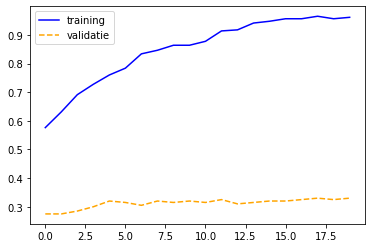

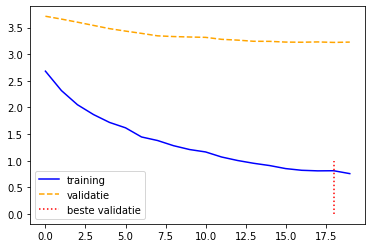

In [34]:
train_loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
best_val_idx = np.argmin(val_loss_values)
num_epochs = range(len(train_loss_values))

plt.plot(num_epochs, train_loss_values, label='training', color='blue', ls='-')
plt.plot(num_epochs, val_loss_values, label='validatie', color='orange', ls='--')
plt.vlines(x=best_val_idx, ymin=0, ymax=1, label='beste validatie', color='red', ls=':')
plt.legend()
plt.figure(0)
train_loss_values = history.history['sparse_categorical_accuracy']
val_loss_values = history.history['val_sparse_categorical_accuracy']
num_epochs = range(len(train_loss_values))

plt.plot(num_epochs, train_loss_values, label='training', color='blue', ls='-')
plt.plot(num_epochs, val_loss_values, label='validatie', color='orange', ls='--')
plt.legend()
plt.figure(1)
plt.show()

In [35]:
loss, categorical_accuracy = model_TL_complex_finetune2.evaluate(test_ds, verbose=1)
loss, categorical_accuracy 

32/32 [==============================] - 4s 114ms/step - loss: 3.2801 - sparse_categorical_accuracy: 0.3230


(3.2800681591033936, 0.3230000138282776)

In [36]:
model_TL_complex_finetune2.save_weights('EfficientNetB3_complex_finetuned2.h5')

this approach yielded the best results untill now

### EfficientNetB3 fully training the model

In [37]:
EfficientNetB3=tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(img_width, img_width, 3),
    classes=101,
)

we will train the whole model at once

In [38]:
EfficientNetB3.trainable=True

In [39]:
model_TL = tf.keras.Sequential([
    EfficientNetB3,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(101, activation='softmax'),
])

In [40]:
model_TL.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

model_TL.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 7, 7, 1536)        10783535  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1536)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               196736    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 101)               13029     
Total params: 10,993,300
Trainable params: 10,905,997
Non-trainable params: 87,303
_________________________________________________________________


In [41]:
EPOCHS=20

with tf.device('/GPU:0'):
    hist = model_TL.fit(
        train_ds,
        validation_data = val_ds,
        epochs = 20,
        callbacks=[early_stopping, plateau],
    )

Epoch 1/20
25/25 [==============================] - 32s 704ms/step - loss: 4.6199 - sparse_categorical_accuracy: 0.0188 - val_loss: 4.4614 - val_sparse_categorical_accuracy: 0.0300
Epoch 2/20
25/25 [==============================] - 16s 631ms/step - loss: 3.7827 - sparse_categorical_accuracy: 0.1875 - val_loss: 4.3436 - val_sparse_categorical_accuracy: 0.1150
Epoch 3/20
25/25 [==============================] - 16s 626ms/step - loss: 2.7566 - sparse_categorical_accuracy: 0.4200 - val_loss: 4.2073 - val_sparse_categorical_accuracy: 0.1750
Epoch 4/20
25/25 [==============================] - 15s 616ms/step - loss: 1.9263 - sparse_categorical_accuracy: 0.5813 - val_loss: 4.4711 - val_sparse_categorical_accuracy: 0.1550
Epoch 5/20
25/25 [==============================] - 15s 617ms/step - loss: 1.1316 - sparse_categorical_accuracy: 0.7525 - val_loss: 4.6038 - val_sparse_categorical_accuracy: 0.1500
Epoch 6/20
25/25 [==============================] - 16s 648ms/step - loss: 0.6368 - sparse_cate

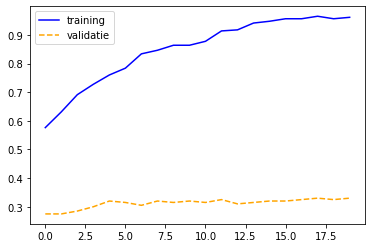

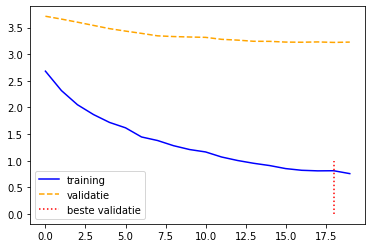

In [42]:
train_loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
best_val_idx = np.argmin(val_loss_values)
num_epochs = range(len(train_loss_values))

plt.plot(num_epochs, train_loss_values, label='training', color='blue', ls='-')
plt.plot(num_epochs, val_loss_values, label='validatie', color='orange', ls='--')
plt.vlines(x=best_val_idx, ymin=0, ymax=1, label='beste validatie', color='red', ls=':')
plt.legend()
plt.figure(0)
train_loss_values = history.history['sparse_categorical_accuracy']
val_loss_values = history.history['val_sparse_categorical_accuracy']
num_epochs = range(len(train_loss_values))

plt.plot(num_epochs, train_loss_values, label='training', color='blue', ls='-')
plt.plot(num_epochs, val_loss_values, label='validatie', color='orange', ls='--')
plt.legend()
plt.figure(1)
plt.show()

In [43]:
loss, categorical_accuracy = model_TL.evaluate(test_ds, verbose=1)
loss, categorical_accuracy 

32/32 [==============================] - 4s 113ms/step - loss: 5.4340 - sparse_categorical_accuracy: 0.1670


(5.433960914611816, 0.16699999570846558)

In [44]:
model_TL.save_weights('EfficientNetB3_full_train.h5')

this is what we already had expected, by training the whole model at once we are actually not using it on it's full potential. Because our source domain is different from our destination domain we are ruining the pretrained weights. We can train our model longer and might get better results but is not our purpose. We want to use a pretrained model so our training time is shorter.

until now we only used the HDF5 files whuch provided us with 1000 training images. From the experiments above we learned that the best method was **EfficientNetB3 with different fine tuning approach**. We will now use that same approach but on a 80% of the whole dataset and use the last 20% as test images